In [78]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import scipy
import scipy.optimize as opt

matplotlib.rcParams.update({'font.size': 12})
colors = [matplotlib.colors.to_rgb(c) for c in matplotlib.pyplot.rcParams['axes.prop_cycle'].by_key()['color']]
print(colors[0][0])

0.12156862745098039


In [9]:
df = pd.read_csv("AoNvsLeaky_demo.csv")

Plot case with no conf PCR and varying adherence

In [10]:
Scenarios = np.sort(np.unique(df["Scenario"]))


Do adherence loop

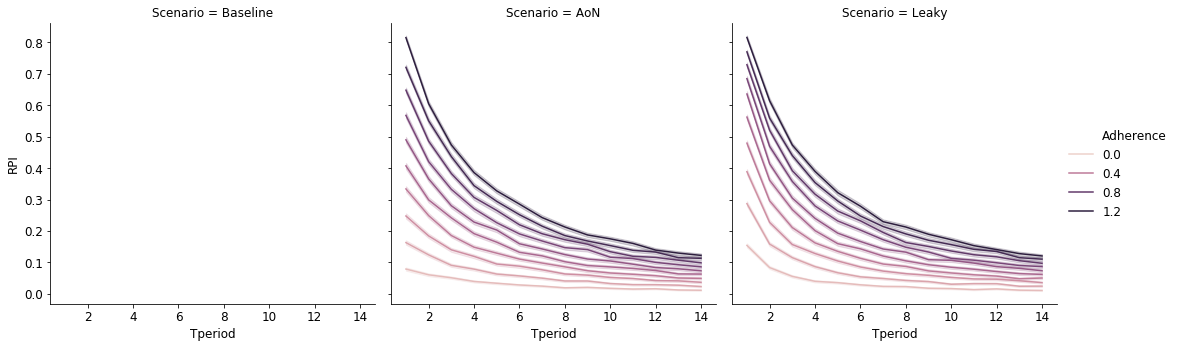

In [12]:
sn.relplot(x="Tperiod",y="RPI",hue="Adherence",col="Scenario",kind="line",data=df)

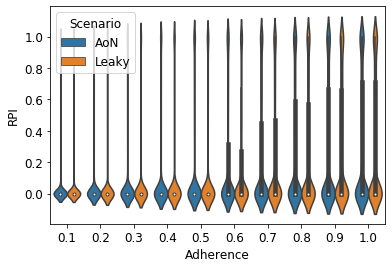

In [19]:
sn.violinplot(x="Adherence",y="RPI",hue="Scenario",data=df.loc[df["Tperiod"]==5.0])

In [42]:
def simple_aon_model(params, adh, tper):
    return adh*params[0]*(1-(1-params[1])**(params[2]/tper)) 

def simple_aon_model_res(params, adh, tper, y):
    return (simple_aon_model(params, adh, tper) - y)**2

def simple_leaky_model(params, adh, tper):
    return params[0]*(1-(1-params[1])**(adh*params[2]/tper))

def simple_leaky_model_res(params, adh, tper, y):
    return (simple_leaky_model(params, adh, tper) - y)**2

df_aon = df.loc[df["Scenario"] == "AoN"]
df_leaky = df.loc[df["Scenario"] == "Leaky"]
A = np.unique(df_aon["Adherence"])
T = np.unique(df_aon["Tperiod"])
Agrid = np.zeros((len(A),len(T)))
Tgrid = np.zeros((len(A),len(T)))
RPI_mean_aon = np.zeros((len(A),len(T)))
RPI_mean_leaky = np.zeros((len(A),len(T)))
for (i,a) in enumerate(A):
    for (j,t) in enumerate(T):
        dfh = df.loc[(df["Adherence"]==a) & (df["Tperiod"]==t)]
        RPI_mean_aon[i,j] = np.mean(dfh.loc[dfh["Scenario"]=="AoN","RPI"])
        RPI_mean_leaky[i,j] = np.mean(dfh.loc[dfh["Scenario"]=="Leaky","RPI"])
        Agrid[i,j] = a
        Tgrid[i,j] = t
x0 = [1.0, 0.5, 3.0]
res_aon = opt.least_squares(simple_aon_model_res, x0, bounds=([0.0,0.0,0.0],[1.0,1.0,14.0]),\
                            args=(Agrid.flatten(), Tgrid.flatten(), RPI_mean_aon.flatten()))
res_leaky = opt.least_squares(simple_leaky_model_res, x0, bounds=([0.0,0.0,0.0],[1.0,1.0,14.0]),\
                            args=(Agrid.flatten(), Tgrid.flatten(), RPI_mean_leaky.flatten()))

In [60]:
print(res_aon.x, res_leaky.x)
x_mean = 0.5*(np.array(res_aon.x) + np.array(res_leaky.x))

[0.92137411 0.50549732 3.03982922] [0.92413802 0.49114282 2.97502288]


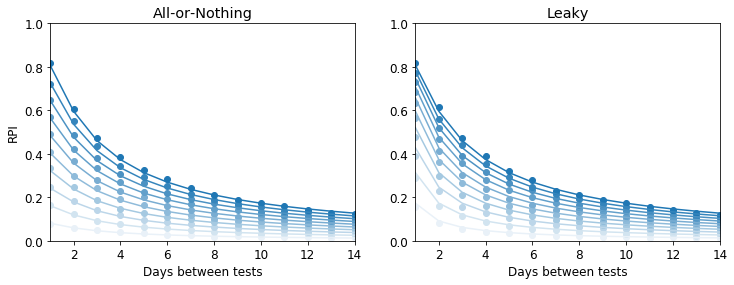

In [87]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
RPI_model_aon = np.zeros((len(A),len(T)))
RPI_model_leaky = np.zeros((len(A),len(T)))

for (i,a) in enumerate(A):
    for (j,t) in enumerate(T):
        RPI_model_aon[i,j] = simple_aon_model(x_mean, a, t)
        RPI_model_leaky[i,j] = simple_leaky_model(x_mean, a, t)
    ch = a*np.array(colors[0]) + (1-a)*np.array([1.0,1.0,1.0])
    ax[0].scatter(T, RPI_mean_aon[i,:], color = ch)
    ax[1].scatter(T, RPI_mean_leaky[i,:], color = ch)
    ax[0].plot(T, RPI_model_aon[i,:], c = ch)
    ax[1].plot(T, RPI_model_leaky[i,:], c = ch)
for i in [0,1]:
    ax[i].set_xlim((1,14))
    ax[i].set_ylim((0,1.0))
    ax[i].set_xlabel("Days between tests")
ax[0].set_ylabel('RPI')
ax[0].set_title('All-or-Nothing')
ax[1].set_title('Leaky')
fig.savefig('AoN_vs_leaky.png')

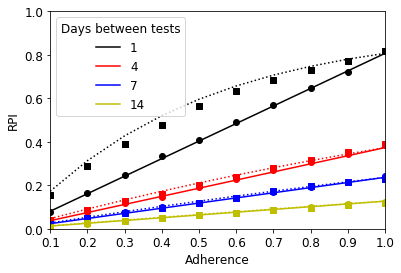

In [76]:
colors = ['k','r','b','y']
for (nj,j) in enumerate([0,3,6,13]):
    plt.plot(A, RPI_model_aon[:,j], c=colors[nj],label='%d'%T[j])
    plt.plot(A, RPI_model_leaky[:,j],':', c=colors[nj])
    plt.scatter(A, RPI_mean_aon[:,j], marker='o', color=colors[nj])
    plt.scatter(A, RPI_mean_leaky[:,j], marker='s', color=colors[nj])
plt.legend(title="Days between tests")
plt.xlabel("Adherence")
plt.ylabel("RPI")
plt.xlim((0.1,1.0))
plt.ylim((0.0,1.0))
plt.savefig('AoN_vs_leaky_adh.png')